In [11]:
import os, pandas as pd

def make_labels(root_dir, out_csv):
    exts = (".jpg",".jpeg",".png",".bmp",".tiff")
    rows=[]
    for class_name in sorted(os.listdir(root_dir)):
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_dir): continue
        for fname in sorted(os.listdir(class_dir)):
            if fname.lower().endswith(exts):
                rows.append({"filename": os.path.join(class_name, fname), "label": class_name})
    pd.DataFrame(rows).to_csv(out_csv, index=False)
    print(f"{out_csv} -> {len(rows)} samples")

make_labels(r"D:\2. ASSIGNMENTS\6-DATH\brisc2025\classification_task\train", "train_labels.csv")
make_labels(r"D:\2. ASSIGNMENTS\6-DATH\brisc2025\classification_task\test", "test_labels.csv")

train_labels.csv -> 5000 samples
test_labels.csv -> 1000 samples


In [12]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from joblib import Parallel, delayed, dump, load

from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ---------- User config (chỉnh theo máy bạn) ----------
TRAIN_IMG_DIR = r"D:\2. ASSIGNMENTS\6-DATH\brisc2025\classification_task\train"
TRAIN_LABEL_CSV = r"D:\2. ASSIGNMENTS\6-DATH\Brain-Tumor-Classification-4ways\svm\train_labels.csv"

TEST_IMG_DIR = r"D:\2. ASSIGNMENTS\6-DATH\brisc2025\classification_task\test"
TEST_LABEL_CSV = r"D:\2. ASSIGNMENTS\6-DATH\Brain-Tumor-Classification-4ways\svm\test_labels.csv"

IMG_SIZE = (224, 224)
ORIENTATIONS = 9
PIXELS_PER_CELL = (16,16)
CELLS_PER_BLOCK = (2,2)
HOG_CHANNEL = 'grayscale'
PCA_VARIANCE = 0.95
RANDOM_STATE = 42
N_JOBS = 8

SAVE_FEATURES = True
TRAIN_FEATURES_FILE = "hog_features_train.npy"
TRAIN_LABELS_FILE = "hog_labels_train.npy"
TEST_FEATURES_FILE = "hog_features_test.npy"
TEST_LABELS_FILE = "hog_labels_test.npy"
SCALER_FILE = "scaler.joblib"
PCA_FILE = "pca.joblib"
SVM_FILE = "svm_model.joblib"
# ------------------------------------------------------

# --- helper: load csv ---
df_train = pd.read_csv(TRAIN_LABEL_CSV)
df_test = pd.read_csv(TEST_LABEL_CSV)

train_filenames = df_train['filename'].tolist()
train_labels = df_train['label'].tolist()
test_filenames = df_test['filename'].tolist()
test_labels = df_test['label'].tolist()

# map labels -> integers consistently across train and test
classes = sorted(list(set(train_labels)))  # assume test labels subset of train labels
label2idx = {lab:i for i,lab in enumerate(classes)}
idx2label = {i:lab for lab,i in label2idx.items()}

y_train_all = np.array([label2idx[l] for l in train_labels])
y_test_all = np.array([label2idx[l] for l in test_labels])

In [13]:
# --- HOG extraction function ---
def extract_hog_for_path(path, img_size=IMG_SIZE,
                         orientations=ORIENTATIONS,
                         pixels_per_cell=PIXELS_PER_CELL,
                         cells_per_block=CELLS_PER_BLOCK,
                         channel=HOG_CHANNEL):
    try:
        img = Image.open(path).convert('RGB')
        img = np.array(img)
    except Exception as e:
        raise RuntimeError(f"Cannot load {path}: {e}")
    if channel == 'grayscale':
        img = rgb2gray(img)
    img_resized = resize(img, img_size, anti_aliasing=True)  # float in [0,1]
    if channel == 'grayscale':
        hog_vec = hog(img_resized,
                      orientations=orientations,
                      pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block,
                      block_norm='L2-Hys',
                      transform_sqrt=True,
                      feature_vector=True)
    else:
        hog_channels = []
        for c in range(3):
            ch = img_resized[..., c]
            hog_c = hog(ch,
                        orientations=orientations,
                        pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block,
                        block_norm='L2-Hys',
                        transform_sqrt=True,
                        feature_vector=True)
            hog_channels.append(hog_c)
        hog_vec = np.concatenate(hog_channels, axis=0)
    return hog_vec

Loaded saved TRAIN features: (5000, 6084)


Extracting HOG from D:\2. ASSIGNMENTS\6-DATH\brisc2025\classification_task\test: 100%|██████████| 1000/1000 [00:03<00:00, 280.68it/s]


Extracted TEST HOG shape: (1000, 6084)
PCA reduced dims: 1109
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params (from train CV): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Classification report (test):
              precision    recall  f1-score   support

      glioma       0.98      0.94      0.96       254
  meningioma       0.95      0.96      0.95       306
    no_tumor       0.97      0.99      0.98       140
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



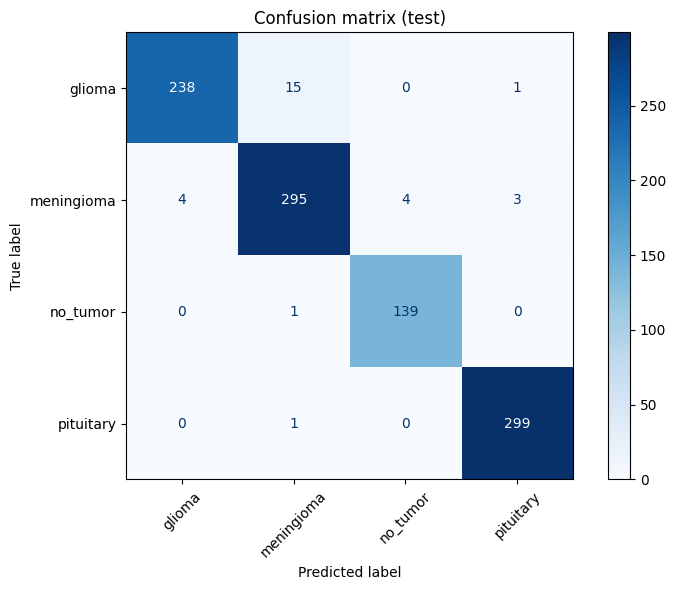

In [14]:
# --- extract features helper with parallel ---
def extract_features_for_list(img_dir, filenames, out_features_file=None, out_labels_file=None, labels_array=None):
    # build absolute paths
    paths = [os.path.join(img_dir, f) for f in filenames]
    # verify existence quickly
    missing = [p for p in paths if not os.path.exists(p)]
    if missing:
        print(f"Warning: {len(missing)} files not found, example: {missing[:5]}")
        # you may want to error out instead
    results = Parallel(n_jobs=N_JOBS)(
        delayed(extract_hog_for_path)(p) for p in tqdm(paths, desc=f"Extracting HOG from {img_dir}")
    )
    X = np.stack(results, axis=0)
    if out_features_file:
        np.save(out_features_file, X)
    if out_labels_file and labels_array is not None:
        np.save(out_labels_file, labels_array)
    return X

# --- 1) features: train ---
if SAVE_FEATURES and os.path.exists(TRAIN_FEATURES_FILE) and os.path.exists(TRAIN_LABELS_FILE):
    X_train = np.load(TRAIN_FEATURES_FILE)
    y_train = np.load(TRAIN_LABELS_FILE)
    print("Loaded saved TRAIN features:", X_train.shape)
else:
    X_train = extract_features_for_list(TRAIN_IMG_DIR, train_filenames,
                                        out_features_file=TRAIN_FEATURES_FILE,
                                        out_labels_file=TRAIN_LABELS_FILE,
                                        labels_array=y_train_all)
    y_train = y_train_all
    print("Extracted TRAIN HOG shape:", X_train.shape)

# --- 2) features: test ---
if SAVE_FEATURES and os.path.exists(TEST_FEATURES_FILE) and os.path.exists(TEST_LABELS_FILE):
    X_test = np.load(TEST_FEATURES_FILE)
    y_test = np.load(TEST_LABELS_FILE)
    print("Loaded saved TEST features:", X_test.shape)
else:
    X_test = extract_features_for_list(TEST_IMG_DIR, test_filenames,
                                       out_features_file=TEST_FEATURES_FILE,
                                       out_labels_file=TEST_LABELS_FILE,
                                       labels_array=y_test_all)
    y_test = y_test_all
    print("Extracted TEST HOG shape:", X_test.shape)

# --- 3) scale: fit on train only ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
dump(scaler, SCALER_FILE)

# --- 4) PCA: fit on train only ---
pca = PCA(n_components=PCA_VARIANCE, svd_solver='full', random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
dump(pca, PCA_FILE)
print("PCA reduced dims:", X_train_pca.shape[1])

# --- 5) SVM tuning on train (GridSearchCV with StratifiedKFold) ---
svc = SVC(decision_function_shape='ovo', probability=False, class_weight='balanced')

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(svc, param_grid, cv=cv, scoring='f1_macro', n_jobs=4, verbose=2)
grid.fit(X_train_pca, y_train)

print("Best params (from train CV):", grid.best_params_)
best_svm = grid.best_estimator_
dump(best_svm, SVM_FILE)

# --- 6) Evaluate on test set (final) ---
y_pred = best_svm.predict(X_test_pca)
print("Classification report (test):")
print(classification_report(y_test, y_pred, target_names=[idx2label[i] for i in range(len(idx2label))]))

# confusion matrix (vẽ)
cm = confusion_matrix(y_test, y_pred)
labels_display = [idx2label[i] for i in range(len(idx2label))]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
ax.set_title("Confusion matrix (test)")
plt.tight_layout()
plt.show()
